In [96]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models import VGAE
import numpy as np
import json
from core.utils import * 

In [356]:
def normalize(data, return_mean_std=False):
    """
    Computes the mean and standard deviation of the input data and stores them.
    
    Args:
        data (torch.Tensor): Input data tensor of shape [num_samples, num_features].
        save_path (str): File path to save the normalization parameters.
        
    Returns:
        torch.Tensor: Normalized data.
    """
    mean = data.mean(dim=0)
    std = data.std(dim=0)
    if return_mean_std :
        return (data - mean) / std, mean , std
    # Return normalized data
    return (data - mean) / std

In [175]:
# Encoder definition with conditional material parameters
class Encoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, material_dim):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(input_dim + material_dim, hidden_dim)  # Conditional input with material parameters
        self.conv_mu = GCNConv(hidden_dim, latent_dim)  # Mean of latent distribution
        self.conv_logvar = GCNConv(hidden_dim, latent_dim)  # Log-variance of latent distribution

    def forward(self, mesh_node, edge_index, material_params):
        # Concatenate material parameters to node features
        mesh_node = normalize(mesh_node)
        x = torch.cat([mesh_node, material_params], dim=1)
        x = F.relu(self.conv1(x, edge_index))  # Apply GCNConv with material parameters
        mu = self.conv_mu(x, edge_index)
        logvar = self.conv_logvar(x, edge_index)
        return mu, logvar


# Decoder definition using latent space and material parameters
class GraphDecoder(torch.nn.Module):
    def __init__(self, latent_dim, output_dim, material_dim):
        super(GraphDecoder, self).__init__()
        self.conv1 = GCNConv(latent_dim + material_dim, latent_dim)  # Conditional input with material parameters
        self.conv2 = GCNConv(latent_dim, output_dim)

    def forward(self, z, edge_index, material_params):
        # Concatenate material parameters to the latent space z
        z = torch.cat([z, material_params], dim=1)
        x = F.relu(self.conv1(z, edge_index))  # Apply GCNConv with material parameters
        x = self.conv2(x, edge_index)
        return x


# Complete CVAE model using VGAE with conditional decoder
class CVGAEWithDeformationDecoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(CVGAEWithDeformationDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def encode(self, x, edge_index, material_params):
        mu, logvar = self.encoder(x, edge_index, material_params)
        return mu, logvar

    def decode(self, z, edge_index, material_params):
        return self.decoder(z, edge_index, material_params)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std


In [66]:
def triangles_to_edges(faces):
    """Computes mesh edges from triangles."""
    # collect edges from triangles
    edges = torch.cat((faces[:, 0:2],
                           faces[:, 1:3],
                           torch.stack((faces[:, 2], faces[:, 0]), dim=1)), dim=0)
    # those edges are sometimes duplicated (within the mesh) and sometimes
    # single (at the mesh boundary).
    # sort & pack edges as single tf.int64
    receivers, _ = torch.min(edges, dim=1)
    senders, _ = torch.max(edges, dim=1)

    packed_edges = torch.stack((senders, receivers), dim=1)
    unique_edges = torch.unique(packed_edges, return_inverse=False, return_counts=False, dim=0)
    senders, receivers = torch.unbind(unique_edges, dim=1)
    senders = senders.to(torch.int64)
    receivers = receivers.to(torch.int64)

    two_way_connectivity = (torch.cat((senders, receivers), dim=0), torch.cat((receivers, senders), dim=0))
    return {'two_way_connectivity': two_way_connectivity, 'senders': senders, 'receivers': receivers}
    

In [67]:
import json

# Open and read the JSON file
with open("dataset/params_desc/G_K_indices.json", "r") as file:
    meta = json.load(file)

# Print the content
print(meta)

{'G_list': [60000000000.0, 62068965517.24138, 64137931034.48276, 66206896551.72414, 68275862068.965515, 70344827586.2069, 72413793103.44827, 74482758620.68965, 76551724137.93103, 78620689655.17241, 80689655172.41379, 82758620689.65517, 84827586206.89655, 86896551724.13794, 88965517241.3793, 91034482758.6207, 93103448275.86206, 95172413793.10345, 97241379310.34482, 99310344827.58621, 101379310344.82758, 103448275862.06897, 105517241379.31033, 107586206896.55173, 109655172413.7931, 111724137931.03448, 113793103448.27586, 115862068965.51724, 117931034482.75862, 120000000000.0], 'K_list': [80000000000.0, 82758620689.65517, 85517241379.31035, 88275862068.96552, 91034482758.6207, 93793103448.27586, 96551724137.93103, 99310344827.58621, 102068965517.24138, 104827586206.89655, 107586206896.55173, 110344827586.2069, 113103448275.86206, 115862068965.51724, 118620689655.17241, 121379310344.82758, 124137931034.48276, 126896551724.13794, 129655172413.7931, 132413793103.44827, 135172413793.10345, 13

In [176]:
g = 9
k = 23
data1 = np.load(f"dataset/disp_field_{g}_{k}.npz")
mesh_pos = data1['mesh_pos']
node_connectivity = torch.tensor(data1['node_connectivity'])
u = data1['u']
decomposed_connectivity = triangles_to_edges(node_connectivity)['two_way_connectivity']
edge_index = torch.cat((decomposed_connectivity[0].reshape(1, -1), decomposed_connectivity[1].reshape(1, -1)), dim=0)

In [201]:
G_tensor = torch.tensor(meta['G_list']).reshape(-1, 1)
K_tensor = torch.tensor(meta['K_list']).reshape(-1, 1)
material_list = torch.cat((G_tensor, K_tensor), dim = 1)
materials_mean = material_list.mean(dim = 0)
materials_std = material_list.std(dim = 0)

In [205]:
nodal_material_params = [(meta["G_list"][g] - materials_mean[0])/materials_std[0], (meta["K_list"][k] - materials_mean[1])/materials_std[1]]

In [206]:
nodal_material_params

[tensor(-0.6248), tensor(0.9655)]

In [ ]:
# Example Data
G_tensor = torch.tensor(meta['G_list']).reshape(-1, 1)
K_tensor = torch.tensor(meta['K_list']).reshape(-1, 1)
material_list = torch.cat((G_tensor, K_tensor), dim = 1)
nodal_material_params = [meta["G_list"][g], meta["G_list"][k]]

normalized_nodal_material_params = [(meta["G_list"][g] - materials_mean[0])/materials_std[0], (meta["K_list"][k] - materials_mean[1])/materials_std[1]]

node_features = torch.tensor(mesh_pos, dtype=torch.float)  # Node feature
edge_index = edge_index
material_params = torch.tensor(normalized_nodal_material_params).repeat(node_features.shape[0], 1) # Material parameters
gt_displacement = torch.tensor(u, dtype=torch.float)  # Target node values
# Model Initialization
input_dim = node_features.shape[1]
hidden_dim = 256
latent_dim = 64
output_dim = 2  # Predict scalar nodal values
material_dim = material_params.shape[1]

encoder = Encoder(input_dim, hidden_dim, latent_dim, material_dim)
decoder = GraphDecoder(latent_dim, output_dim, material_dim)
model = CVGAEWithDeformationDecoder(encoder, decoder)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
normalized_gt_displacement, mean_gt, std_gt = normalize(torch.tensor(u, dtype=torch.float), True)
# Training Loop
model.train()
for epoch in range(5000):
    optimizer.zero_grad()

    # Encode to latent space
    mu, logvar = model.encode(node_features, edge_index, material_params)
    z = model.reparameterize(mu, logvar)
    # Decode to predict nodal values
    predictions = model.decode(z, edge_index, material_params).squeeze()

    # Compute reconstruction loss (e.g., MSE)
    reconstruction_loss = F.mse_loss(predictions, normalized_gt_displacement)

    # Compute KL divergence
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.0001
    # Total loss (reconstruction loss + KL divergence)
    loss = reconstruction_loss + kl_divergence

    # Backpropagation
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.8940547108650208
Epoch 2, Loss: 0.38004356622695923
Epoch 3, Loss: 0.5050811171531677
Epoch 4, Loss: 0.29173213243484497
Epoch 5, Loss: 0.3892554044723511
Epoch 6, Loss: 0.384235680103302
Epoch 7, Loss: 0.3635786771774292
Epoch 8, Loss: 0.3635479509830475
Epoch 9, Loss: 0.3087341785430908
Epoch 10, Loss: 0.24306637048721313
Epoch 11, Loss: 0.32131847739219666
Epoch 12, Loss: 0.27094170451164246
Epoch 13, Loss: 0.2559680640697479
Epoch 14, Loss: 0.24271482229232788
Epoch 15, Loss: 0.23951455950737
Epoch 16, Loss: 0.2743592858314514
Epoch 17, Loss: 0.256962388753891
Epoch 18, Loss: 0.22869417071342468
Epoch 19, Loss: 0.2592237591743469
Epoch 20, Loss: 0.24235671758651733
Epoch 21, Loss: 0.2255658060312271
Epoch 22, Loss: 0.23297126591205597
Epoch 23, Loss: 0.20761144161224365
Epoch 24, Loss: 0.22646737098693848
Epoch 25, Loss: 0.21918821334838867
Epoch 26, Loss: 0.1944027990102768
Epoch 27, Loss: 0.23453649878501892
Epoch 28, Loss: 0.23461081087589264
Epoch 29, Loss: 0.2

In [467]:
predictions = model.decode(z, edge_index, material_params).squeeze()
predictions_unnorm = mean_gt + std_gt * predictions
predictions_unnorm

tensor([[ 2.2078e-06, -3.2112e-07],
        [ 3.7563e-06,  2.7393e-07],
        [ 8.5381e-06,  7.7361e-07],
        [ 1.2265e-05,  1.1550e-06],
        [ 4.3068e-05,  9.5278e-07],
        [ 4.4767e-05, -1.5910e-06],
        [ 1.3082e-05, -1.1190e-06],
        [ 1.3899e-05, -1.5477e-06],
        [ 1.3326e-05,  8.4285e-08],
        [ 3.4358e-05,  1.9948e-07],
        [ 2.0266e-05,  2.5015e-07],
        [ 2.4183e-06, -6.3747e-08],
        [ 4.2098e-06,  3.2365e-07],
        [ 5.6803e-06,  5.7719e-07],
        [ 4.7864e-06,  6.2199e-07],
        [ 1.0184e-06,  4.4144e-07],
        [ 2.4342e-07,  4.8912e-07],
        [ 3.0670e-06,  6.4885e-07],
        [ 5.0389e-06,  8.5167e-07],
        [ 5.1718e-06,  8.7708e-07],
        [ 7.8528e-06,  9.5332e-07],
        [ 8.8371e-06,  8.5622e-07],
        [ 6.5421e-06,  1.0660e-06],
        [ 1.7646e-05,  1.1905e-06],
        [ 1.7769e-05,  1.2075e-06],
        [ 1.3385e-05,  1.4459e-06],
        [ 1.1352e-05,  1.5892e-06],
        [ 1.2815e-05,  1.488

In [468]:
gt_displacement

tensor([[ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 6.2371e-06,  1.5979e-06],
        [ 8.7986e-06,  1.7370e-06],
        [ 5.2044e-05,  1.7502e-06],
        [ 5.2048e-05, -1.8855e-06],
        [ 8.8013e-06, -1.7435e-06],
        [ 6.2487e-06, -1.6005e-06],
        [ 0.0000e+00,  0.0000e+00],
        [ 3.6700e-05, -3.3756e-08],
        [ 2.4114e-05, -3.7764e-08],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 3.2428e-07,  5.5315e-07],
        [ 8.5151e-07,  9.6760e-07],
        [ 1.6182e-06,  1.2197e-06],
        [ 2.5949e-06,  1.3657e-06],
        [ 3.7409e-06,  1.4460e-06],
        [ 4.9760e-06,  1.5130e-06],
        [ 7.5427e-06,  1.6805e-06],
        [ 1.0032e-05,  1.7710e-06],
        [ 1.1261e-05,  1.7897e-06],
        [ 1.2487e-05,  1.7970e-06],
        [ 1.3714e-05,  1.7954e-06],
        [ 1.4943e-05,  1.785

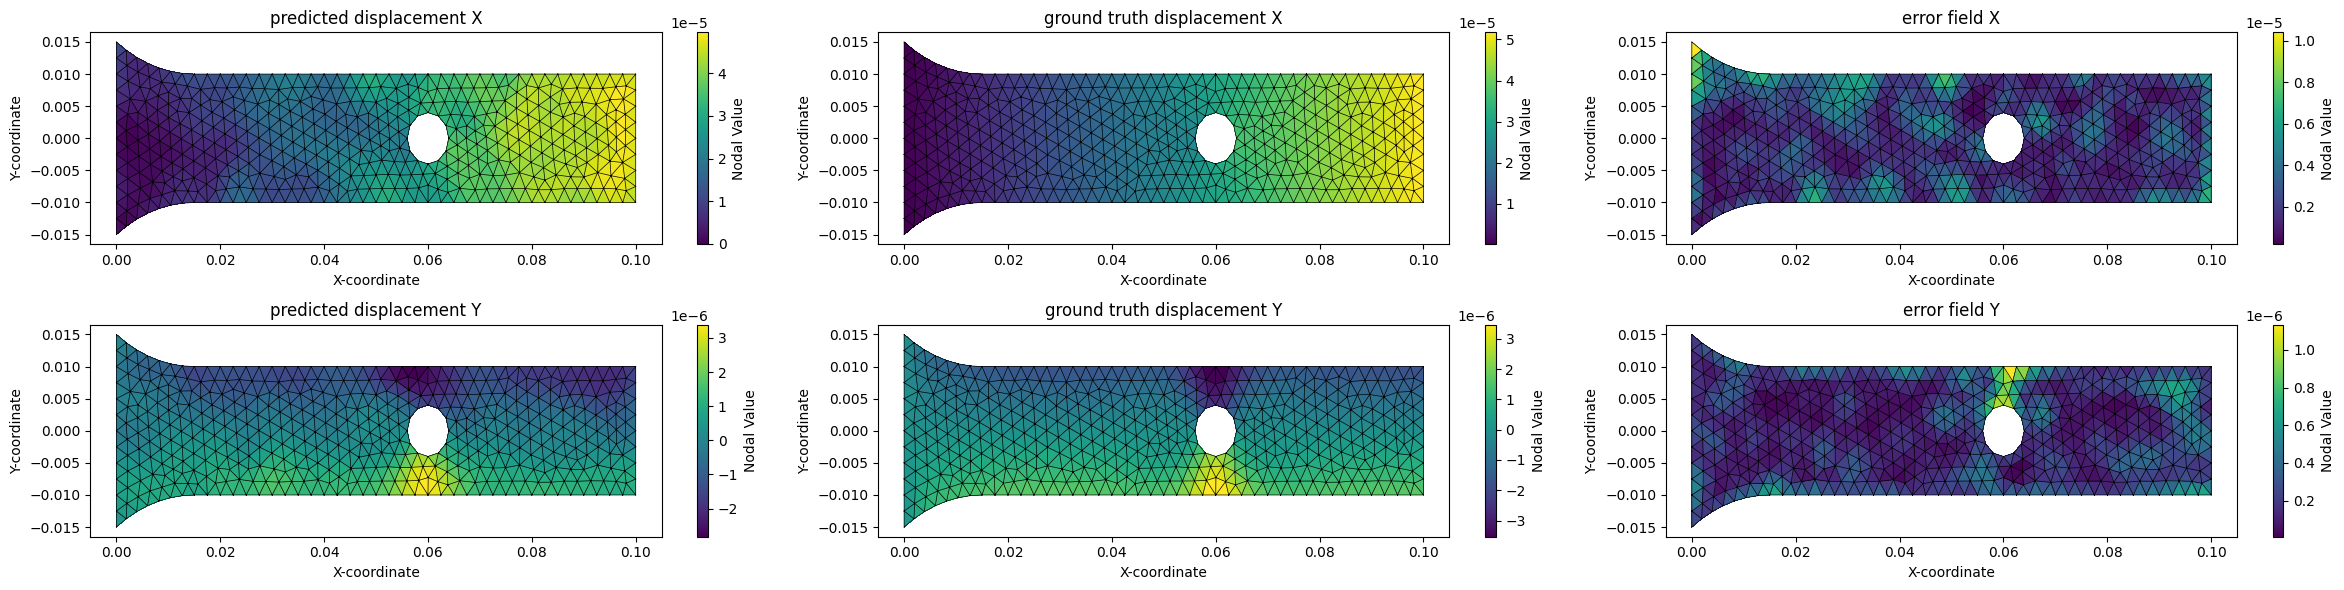

In [469]:
import matplotlib.pyplot as plt
import meshio
import matplotlib.tri as tri
# Read the .msh file

# Get node coordinates
nodes = node_features.detach().numpy()  # Extract the x, y coordinates (for 2D)
predictions_plot = predictions_unnorm.detach().numpy()
plotdata = {"predicted displacement" : predictions_plot, "ground truth displacement": gt_displacement, "error field" : torch.abs((predictions_unnorm - gt_displacement)).detach().numpy()}
# Get connectivity for triangular elements

# Plotting
triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], node_connectivity)

# Create subplots
fig, axes = plt.subplots(2, 3, figsize=(24, 6))  # 2 row, 3 columns

# First subplot
for key, v in plotdata.items() :
    for j in range(2) :
        i = list(plotdata.keys()).index(key)
        if key != "error field" :
            im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
        else :
            im = axes[j][i].tripcolor(triangulation, plotdata[key][:, j], shading='flat', cmap='viridis')
        axes[j][i].triplot(triangulation, color='black', linewidth=0.5)
        if j == 0 :
            axes[j][i].set_title(f"{key} X")
        else :
            axes[j][i].set_title(f"{key} Y")
        axes[j][i].set_xlabel("X-coordinate")
        axes[j][i].set_ylabel("Y-coordinate")
        fig.colorbar(im, ax=axes[j][i], orientation='vertical', label="Nodal Value")

plt.tight_layout()
plt.show()


In [463]:
import torch
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
import os
class MaterialDeformationDataset(Dataset):
    def __init__(self, data_dir):
        """
        Generates synthetic dataset for material deformation use case.

        Args:
            num_graphs (int): Number of graphs in the dataset.
            num_nodes (int): Number of nodes per graph.
            num_features (int): Number of features per node.
            num_material_params (int): Number of material parameters.
        """
        super(MaterialDeformationDataset, self).__init__()
        self.data_dir = data_dir
        self.file_name_list = [filename for filename in os.listdir(data_dir) if not os.path.isdir(os.path.join(data_dir, filename))]
        with open(os.path.join(data_dir, "params_desc/G_K_indices.json"), "r") as file:
            meta = json.load(file)
        # Print the content
        self.meta = meta
    def __len__(self):
        return len(self.file_name_list)

    def __getitem__(self, idx):
        # Randomly generate node features
        file_name = self.file_name_list[idx]
        data = np.load(os.path.join(self.data_dir, file_name))
        i_g = int(file_name.rstrip(".npz").split("_")[2])
        i_k = int(file_name.rstrip(".npz").split("_")[3])

        decomposed_connectivity = triangles_to_edges(torch.tensor(data['node_connectivity']))['two_way_connectivity']
        nodal_material_params = [self.meta["G_list"][i_g], self.meta["G_list"][i_k]]

        u = data["u"]

        mesh_pos = torch.tensor(data["mesh_pos"])
        edge_index = torch.cat((decomposed_connectivity[0].reshape(1, -1), decomposed_connectivity[1].reshape(1, -1)), dim=0)
        material_params = torch.tensor(nodal_material_params).repeat(mesh_pos.shape[0], 1)  # Material parameter
        gt_displacement = torch.tensor(u, dtype=torch.float)  # Target node values

        return Data(mesh_pos = mesh_pos, edge_index = edge_index, material_params = material_params, gt_displacement = gt_displacement)


In [ ]:
normalize(mesh_pos)

In [145]:
dataset = MaterialDeformationDataset("dataset")

In [166]:
sum(normalize(dataset[0].mesh_pos[:, 0]).isclose(normalize(dataset[0].mesh_pos)[:, 0]))

tensor(467)

In [150]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [152]:
data = list(iter(train_loader))

/home/narupanta/anaconda3/envs/fenicsx-env/lib/python3.12/site-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'material_params', 'mesh_pos', 'gt_displacement'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


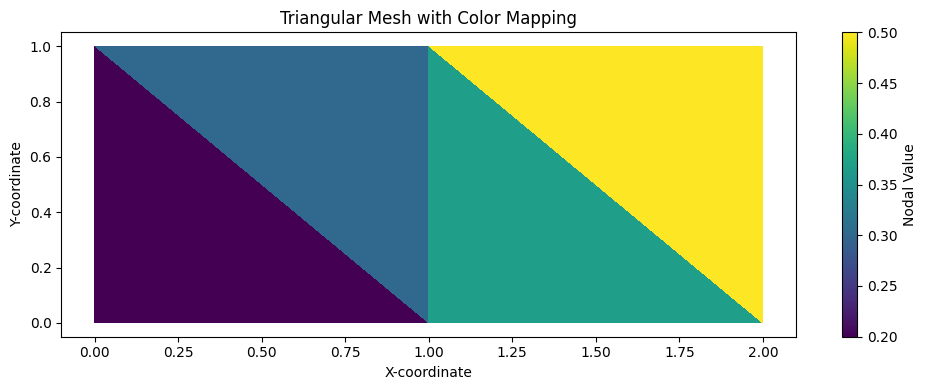

In [300]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np

# Example nodal coordinates
nodes = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1],
    [2, 0],
    [2, 1]
])

# Example node connectivity (triangles)
triangles = np.array([
    [0, 1, 2],
    [1, 3, 2],
    [1, 4, 3],
    [4, 5, 3]
])

# Example nodal values
nodal_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

# Create a Triangulation object
triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], triangles)

# Create the plot
plt.figure(figsize=(10, 4))
plt.tripcolor(triangulation, nodal_values, shading='flat', cmap='viridis')

# Add a color bar
plt.colorbar(label="Nodal Value")

# Add titles and labels
plt.title("Triangular Mesh with Color Mapping")
plt.xlabel("X-coordinate")
plt.ylabel("Y-coordinate")

# Show the plot
plt.tight_layout()
plt.show()
